<a href="https://colab.research.google.com/github/87tana/Image-Semantic-Segmentation/blob/main/Tumor_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [2]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [3]:
# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'


In [4]:
!pip install torchmetrics
import torchmetrics  # Metrics computation for PyTorch models


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [5]:
# General Imports
import os  # Operating system operations
import random
import glob  # File path expansion (finding files matching a pattern)
import json  # JSON serialization and deserialization
import gc  # Garbage collection for memory management
import time  # Time-related functions
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization
import cv2  # OpenCV for image processing
from PIL import Image  # Python Imaging Library for image processing
import skimage.draw  # Drawing primitives on images
from tqdm import tqdm, trange  # Progress bars for loops
from IPython.display import Image  # Displaying images in Jupyter notebooks
from skimage import io  # Image I/O operations

# Data Science and Math Libraries
import numpy as np
import pandas as pd

# Scikit-Learn Imports
from sklearn.preprocessing import StandardScaler, normalize  # Data preprocessing

# PyTorch Imports
import torch
import torch.nn as nn  # Neural network modules and loss functions
import torch.optim as optim  # Optimization algorithms
from torchvision import transforms  # Image transformations
import torchvision  # Computer vision library
from torch.utils.data import DataLoader  # Data loading utility

# Additional Imports
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings
import matplotlib.image as mpimg  # Reading and displaying images




# 2. Data Prepration

## 2.1. Creating DataFrame

To handle the dataset, we initialize a dataframe and extract crucial details from it. This involves parsing annotations stored in JSON files for each subset of the dataset (train, valid, test). For each image, the program locates the corresponding annotation, retrieves pertinent data, and organizes it into lists. In case an annotation is absent for an image, a warning message is printed. Finally, a dictionary named 'dic' is constructed, consolidating all the extracted information.


In [6]:
"""
Read JSON files and extract image and annotation information.
Store them in lists and then create a dictionary.
Finally create a pandas dataframe using the dctionary.
"""

file_name = []
width = []
height = []
category_id = []
segmentation = []
subset = []

for s in ['train', 'valid', 'test']:
  with open(os.path.join(root_dir,s,'_annotations.coco.json'),'r') as file:
    data = json.load(file)
    for id in range(len(data['images'])):
      # Flag to check if the annotation is available
      ann_available=False
      # Look for the corresponding annotation
      for j in range(id,len(data['images'])):
        if data['annotations'][j]['image_id'] == data['images'][id]['id']: # if the aanotation is found,extracted the 'category_id' and 'segmentation' from the annotation and append.
          category_id.append(data['annotations'][j]['category_id'])
          segmentation.append(data['annotations'][j]['segmentation'])
          ann_available=True
          break

      if ann_available:
        file_name.append(data['images'][id]['file_name'])
        width.append(data['images'][id]['width'])
        height.append(data['images'][id]['height'])
        subset.append(s)
      else:
        print(f'Annotation is missing for image {id} in {s}')



dic = {'file_name': file_name, 'width': width , 'height': height,\
        'category_id': category_id, 'segmentation': segmentation, 'subset': subset}

df = pd.DataFrame.from_dict(dic)
df.head()

Annotation is missing for image 1380 in train


,file_name,width,height,category_id,segmentation,subset
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,1,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",train
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,1,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",train
2,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg,640,640,1,"[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295,...",train
3,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg,640,640,1,"[[383.75, 357.5, 245, 357.5, 245, 523.75, 383....",train
4,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg,640,640,1,"[[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5...",train


In [7]:
subset_counts = df['subset'].value_counts()
subset_counts

subset
train    1501
valid     429
test      215
Name: count, dtype: int64

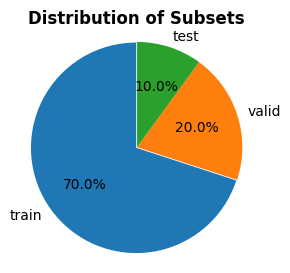

In [8]:
# Count the occurrences of each subset
subset_counts = df['subset'].value_counts()

explode = (0.01, 0, 0)

plt.figure(figsize=(3, 3))
plt.pie(subset_counts, labels=subset_counts.index, autopct='%1.1f%%',startangle=90, explode=explode)
plt.title('Distribution of Subsets', weight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## 2.2 Functiin for mask creation

In [9]:
def create_mask(image_info):

  """ - The function aims to create a binary mask based on the segmentation information provided.
        It iterates over each segmentation entry in the image_info['segmentation'] list.
        it extracts the polygon coordinates from the segmentation list.
        pixels inside the segmented regions are set to 1 and pixels outside are set to 0.
  """
  mask_np = np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)

  for seg_idx ,seg in enumerate(image_info['segmentation']):
      rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
      mask_np[rr,cc]=1

  return mask_np

## 2.3 Data Images Glimpse, Class 1 and Class 2 are both Tumor

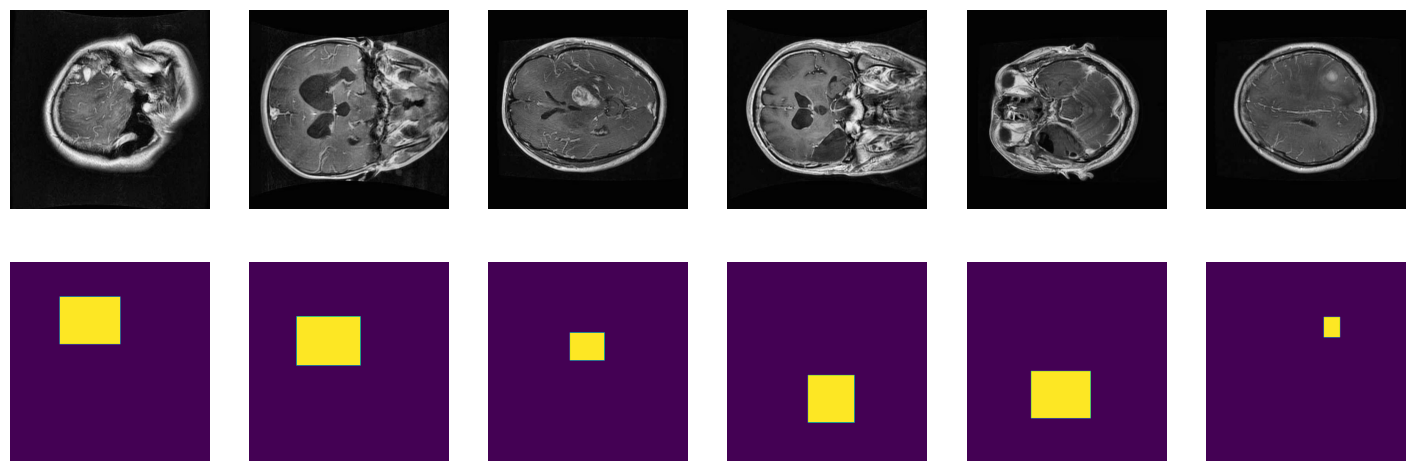

In [10]:
samp = df[df['category_id']==1].sample(6).reset_index(drop=True)

fig, axes = plt.subplots (2,6,figsize=(18,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()


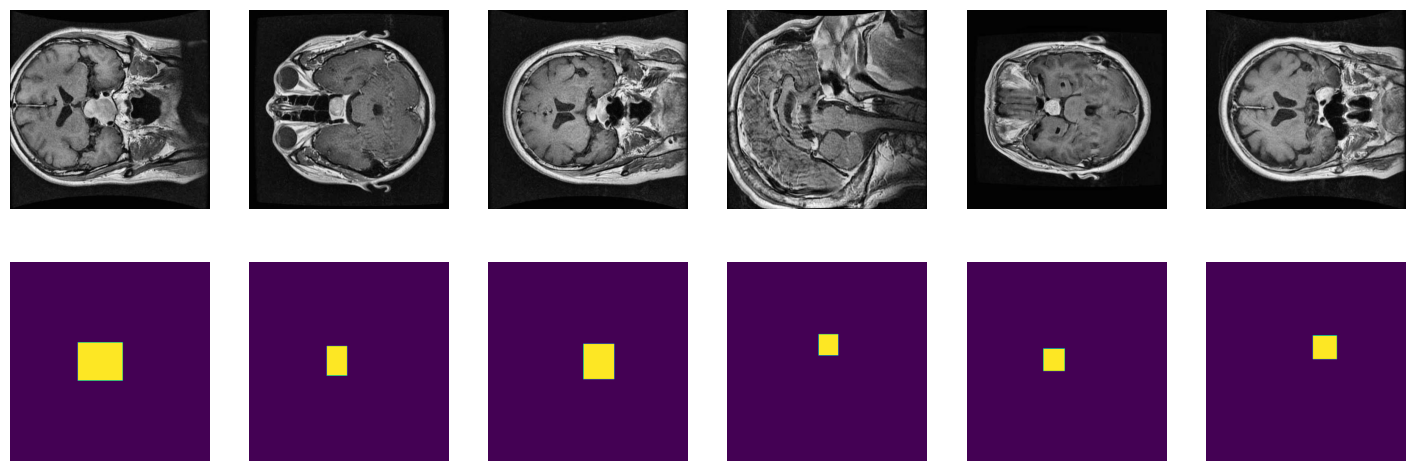

In [11]:
samp = df[df['category_id']==2].sample(6).reset_index(drop=True)

fig, axes = plt.subplots (2,6,figsize=(18,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()

## 3.Dataset Class

In [14]:
"""
Dataset class. Read images and create an iterator used in the dataloader.
"""
class SegmentationDataset():
    def __init__(self, root_dir, df, subset, max_samp=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        if max_samp is None:
          max_samp = len(df)

        self.data_ = []  # Loading image-mask pairs from the dataset into memory and storing them in a list called self.data_.

        for i in tqdm(range(max_samp), desc=subset):
          img = cv2.imread(os.path.join(root_dir,subset,df.loc[i]['file_name']))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          mask = create_mask(df.loc[i]) # Create mask
          self.data_.append({'image': img, 'mask': mask}) # add image and its mask to a list.

    def __len__(self):
        return len(self.data_)

    def __getitem__(self, idx):

        image = self.data_[idx]['image']
        mask = self.data_[idx]['mask']


        if self.transform is not None:
          image = self.transform['image'](image)
          mask = self.transform['mask'](mask)
          mask[mask>0] = 1.0


        return image, mask

a custom dataset class called `SegmentationDataset` for the brain tumor segmentation task. It reads in images and creates an iterator used in the dataloader.

The `__init__` method takes in the root directory of the dataset, a pandas DataFrame `df` containing image and annotation information, and an optional transformation pipeline `transform`. It initializes the `data_` attribute as an empty list.

The `__len__` method returns the length of the `data_` list, which is the number of image-mask pairs in the dataset.

The `__getitem__` method takes in an index `idx` and returns the corresponding image-mask pair. It first extracts the image and mask from the `data_` list using the index. If a transformation pipeline is provided, it applies the `transform` to both the image and mask.

## 4. Data Transformation (augumentation: brightness, normalize, resize the mask)

In [15]:
# Define the mean and standard deviation for normalization  or getting my own mean and std?
#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]

# Define the transformations for images and masks.
transform_img = transforms.Compose([
    #transforms.RandomBrightness(0.1), # Apply random brightness augmentation to improve the contrast and visisbility
    transforms.ToTensor(), # converting image data from a numpy array or PIL image format to a PyTorch tensor format.
    #transforms.Normalize(mean=mean, std=std) # normalize the image
])

transform_mask = transforms.Compose([
   # transforms.RandomBrightness(0.1), # Apply random brightness augmentation
    transforms.ToTensor(),
    transforms.Resize((80, 80)), # convert mask to PyTorch tensor
    #transforms.Normalize(mean=[0], std=[1]) # normalize the mask
])

transform = {'image': transform_img , 'mask': transform_mask}

- obtained from the ImageNet dataset In practice, the mean and standard deviation values for normalization are often hard-coded or stored as constants in the code,

## 5.Creating train, validation and test dataloaders

In [16]:
"""
Create train and validation dataloaders.
"""

# Train dataloader
train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='train'].reset_index(drop=True), subset='train', max_samp=224, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation dataloader.
valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='valid'].reset_index(drop=True), subset='valid', max_samp=50, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=False)

# Test dataloader.
#test_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='test'].reset_index(drop=True), subset='test', max_samp=50, transform=transform)
#test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

valid: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


In [ ]:
# Define sample CNN model for segmentation

class SegmentationCNN(nn.Module):
    def __init__(self):
        super(SegmentationCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, 3, padding=1)  # Output is a single channel for binary segmentation
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.conv4(x)
        return x

New Architecture:

In [17]:
class SamplSegNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SamplSegNet, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)


        #Decoder
        self.conv6 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv9 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv10 = nn.Conv2d(32, 1, 1, padding=0)

        #
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
      #
      x = self.relu(self.conv1(x))
      x = self.pool(x)
      x = self.relu(self.conv2(x))
      x = self.pool(x)
      x = self.relu(self.conv3(x))
      x = self.pool(x)
      x = self.relu(self.conv4(x))
      x = self.pool(x)
      x = self.relu(self.conv5(x))
      x = self.relu(self.conv6(x))
      x = self.up(x)
      x = self.relu(self.conv7(x))
      #x = self.up(x)
      x = self.relu(self.conv8(x))
      #x = self.up(x)
      x = self.relu(self.conv9(x))
      x = self.conv10(x)
      #x = self.sigmoid(self.conv10(x))
      #x = self.softmax()

      return x

In [29]:
# Initialize the model, loss function, and optimizer
# learning rate, batch size, and regularization strength
model = SamplSegNet()
criterion = nn.BCEWithLogitsLoss()  # This loss combines a Sigmoid layer and the BCELoss in one single class.
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

evaluate the difference between the predicted segmentation mask and the ground truth mask.
Common loss functions for segmentation tasks include the Dice loss, cross-entropy loss, and focal loss.

During training, the CNN updates its weights to minimize the difference between the predicted segmentation mask and the ground truth mask.

In [30]:
# Set the max number of epochs, and validation step.
import torch
num_epochs = 50
valid_step = 5
ckpt_step = 30
# Set the device to GPU if availabel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device.
model.to(device)
#print(model)

SamplSegNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='nearest')
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (sigmoid): Sigmoid()
)

In [31]:
x = torch.randn(1, 1, 640, 640).cuda()  # Batch size 1, single channel image of size 80x80
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 80, 80])


In [32]:
# Training loop

sample_val_result = []
train_loss = []
valid_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, (images, masks) in enumerate(train_loader):


        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss.append([epoch, epoch_loss])
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    if epoch % ckpt_step == 0 or epoch == num_epochs-1:
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f'Model_Checkpoints/ckp_{epoch}.pt')


    # Validation
    if epoch % valid_step == 0 or epoch == num_epochs-1:
      model.eval()
      valid_loss_sum = 0
      with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            valid_loss_sum += criterion(outputs, masks).item() * images.size(0)

            sample_val_result.append({'image':images[0], 'mask':masks[0], 'pred':outputs[0]})

        avg_valid_loss = valid_loss_sum / len(valid_loader.dataset)
        valid_loss.append([epoch, avg_valid_loss])
        print(f"Average Valid Loss: {avg_valid_loss:.4f}")



Epoch [1/50], Loss: 0.7447
Average Valid Loss: 0.7379
Epoch [2/50], Loss: 0.7159
Epoch [3/50], Loss: 0.4732
Epoch [4/50], Loss: 0.2882
Epoch [5/50], Loss: 0.2297
Epoch [6/50], Loss: 0.2131
Average Valid Loss: 0.2045
Epoch [7/50], Loss: 0.1985
Epoch [8/50], Loss: 0.1860
Epoch [9/50], Loss: 0.1796
Epoch [10/50], Loss: 0.1744
Epoch [11/50], Loss: 0.1720
Average Valid Loss: 0.1738
Epoch [12/50], Loss: 0.1699
Epoch [13/50], Loss: 0.1679
Epoch [14/50], Loss: 0.1665
Epoch [15/50], Loss: 0.1652
Epoch [16/50], Loss: 0.1641
Average Valid Loss: 0.1646
Epoch [17/50], Loss: 0.1630
Epoch [18/50], Loss: 0.1621
Epoch [19/50], Loss: 0.1614
Epoch [20/50], Loss: 0.1604
Epoch [21/50], Loss: 0.1598
Average Valid Loss: 0.1606
Epoch [22/50], Loss: 0.1590
Epoch [23/50], Loss: 0.1587
Epoch [24/50], Loss: 0.1576
Epoch [25/50], Loss: 0.1569
Epoch [26/50], Loss: 0.1563
Average Valid Loss: 0.1571
Epoch [27/50], Loss: 0.1557
Epoch [28/50], Loss: 0.1552
Epoch [29/50], Loss: 0.1551
Epoch [30/50], Loss: 0.1547
Epoch [

- observation:
- The training loss decreases continiously over epochs, which indicates that the model is learning to fit the training data well

- The validation loss fluctuates but generally decreases over epochs. This indicates that the model is generalizing well to unseen data

- there is consisteny in loss which show not overfitting

- Overall, the decreasing trend in training loss indicates that the model is learning and improving its performance over the course of training.

Text(0.5, 0.98, 'Training and Validation Loss Curves')

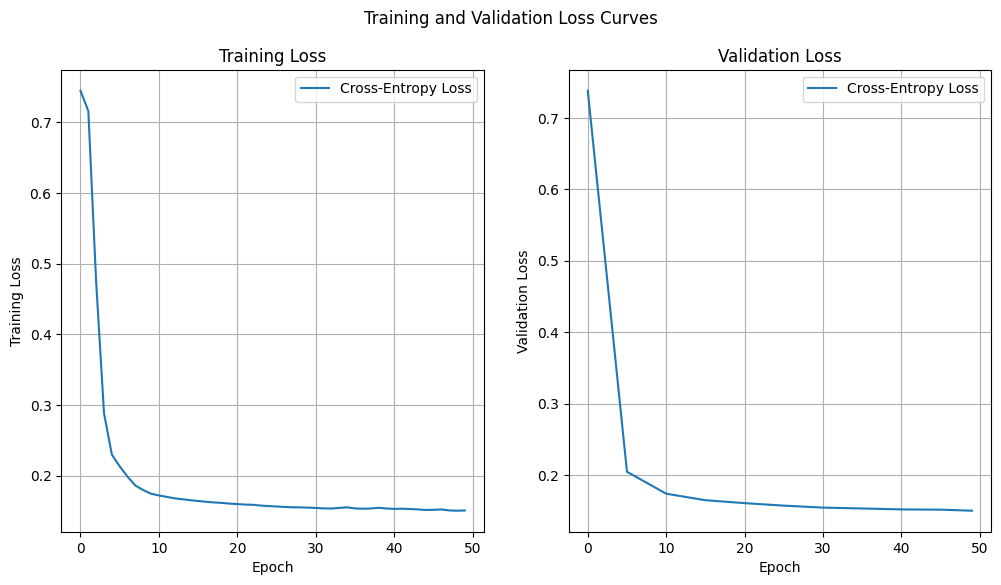

In [33]:
"""
Plot train and validation curves
"""

fig, axes = plt.subplots (1,2,figsize=(12,6))

axes[0].plot(np.vstack(train_loss)[:,0],np.vstack(train_loss)[:,1]) #vertically stack the array---- (train_loss) contains elements of [epoch, epoch_loss] --> 10 0utput because we have 10.
axes[1].plot(np.vstack(valid_loss)[:,0],np.vstack(valid_loss)[:,1])

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[0].legend(['Cross-Entropy Loss'])
axes[0].grid(True)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss')
axes[1].legend(['Cross-Entropy Loss'])
axes[1].grid(True)

fig.suptitle('Training and Validation Loss Curves')


In [34]:
len(sample_val_result)

110

In [35]:
sigmoid = nn.Sigmoid()
sigmoid(sample_val_result[19]['pred']).permute(1, 2, 0).cpu().max()

tensor(0.4204)

(-0.5, 79.5, 79.5, -0.5)

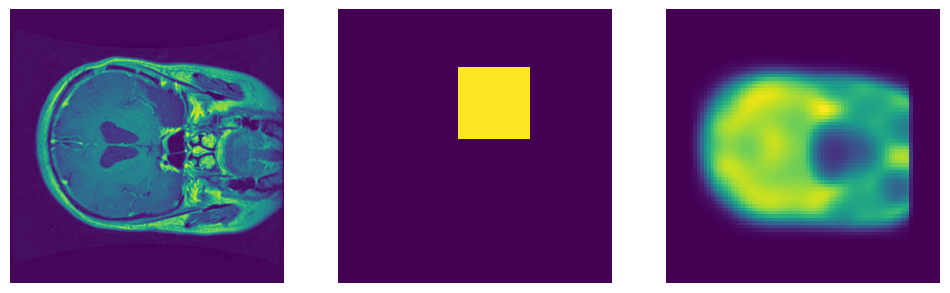

In [36]:
"""
Visualize sample validation result.
"""
sigmoid = nn.Sigmoid()


idx = len(sample_val_result)-3

fig, axes = plt.subplots (1,3,figsize=(12,6))

axes[0].imshow(sample_val_result[idx]['image'].permute(1, 2, 0).cpu())
axes[1].imshow(sample_val_result[idx]['mask'].permute(1, 2, 0).cpu())
axes[2].imshow(sigmoid(sample_val_result[idx]['pred']).permute(1, 2, 0).cpu())

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

In [37]:
def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [38]:
iou(sample_val_result[1]['mask'].permute(1, 2, 0).cpu().numpy(), sample_val_result[1]['pred'].permute(1, 2, 0).cpu().numpy())


0.025